# igv variant classifier

In [1]:
from fastai.vision import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# from PIL import Image

orignal igv screen shot: 1910x1756, 301 base pairs.  
processed image: 800x200, rectangular shape  
network input image: 750x200, i hope this provide image augmentation, crop from top.

some updates/improvement on this:

* during my first shot trial, I simply generated the igv screen shots as training images. There are quite a few shortcomings/ caveats in the image. For example,
      1) the top pane of the igv has the coordinates and a chromosome cytoband model. This should not have any useful information in determining if a variant is real or not.
      2) the left pane of the igv shows the bam file name, this should not have any useful graphic information in dtermining if a variant is real or not either.
      3) currently, images are 500x425 pixels. the resolution seems way too high. therotically for each base, we only need one pixel value. we take a screenshot for 300 base pairs. so set the width to be close to 300 and make the read width to be roughly one pixel. this will save lots of computations.
So I decided to crop out those part of the image.
* I turned off all the image transformations. It does not make sense to random rotate the image, cropping, zooming, warping, vertically flipping. I would like to keep the variant position in the centre of the image. horizontally flipping makes sense since the image should still support the same variants.
* there are some issues with the negative training images. previously, I just random pick some of the positions in the genome, which does not have a variant reported by GIAB project. But some of positions may have insufficient coverage or there is variant right next to the position in question. Also these negative samples are mostly too easy. I should come up with ways to include more challenging negative training set.
* it looks like fastai data block api can actually take rectangular images. will experiment if it works since this is especially relevant to igv screen shots. 


In [2]:
# it looks like this is the way to go: give a rectangular size and let the crop from top centre position (0., 0.5)
fname = '/projects/da_workspace/szspace/data/pog664_posorg/proc/chr11_47,609,711_47,610,011.png'

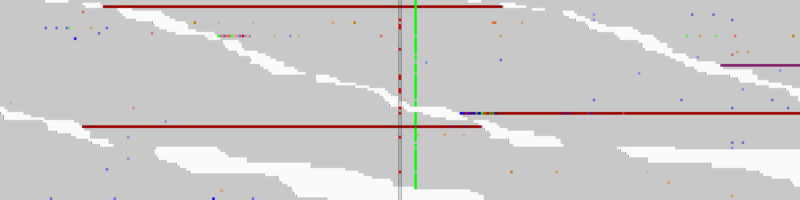

In [15]:
open_image(fname)

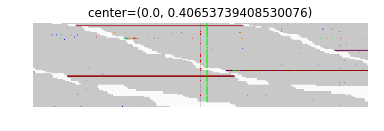

In [7]:
f, ax = plt.subplots()
center = [0., np.random.random()]
crop(open_image(fname), (200, 800), *center).show(ax=ax, title=f'center=({center[0]}, {center[1]})')

In [95]:
doc(RandTransform)

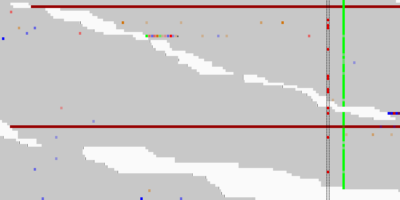

In [250]:
tfm = [crop(size=(200, 400), row_pct=0., col_pct=np.random.rand())]
open_image(fname).apply_tfms(tfm)

# test transformations

why it is not random at all? I dont know why but restar the kernel made randomizing happen. Is it because I set random seeds before?  
ranomization does not work for rectangular images!  
also even I use the full size image, it only show part of the image after tranformation, weird.

torch.Size([3, 800, 800])
torch.Size([3, 800, 800])
torch.Size([3, 800, 800])
torch.Size([3, 800, 800])


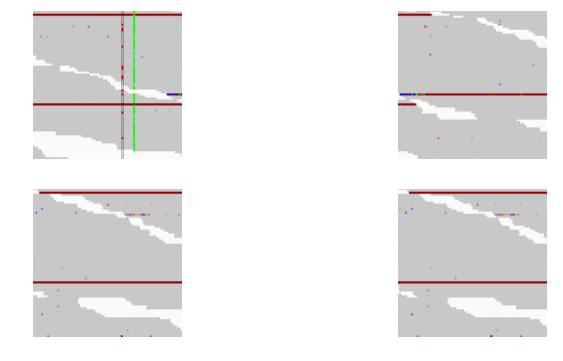

In [30]:
def get_ex(): return open_image('/projects/da_workspace/szspace/data/pog664_posorg/proc/chr11_47,609,711_47,610,011.png')

tfm = rand_crop()
_, axs = plt.subplots(2,2,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex().apply_tfms(tfm, size=800)
    print(img.shape)
    img.show(ax=ax)

In [77]:
get_ex().shape

torch.Size([3, 200, 800])

In [ ]:
open_image(fname).apply_tfms

In [111]:
# verify_images??
# get_image_files??

In [11]:
# for c in classes:
#     print(c)
#     verify_images(path/c, delete=True, max_size=500)

## View data

In [129]:
doc(get_transforms)

In [225]:
tfms = [crop(size=(200, 400), row_pct=0., col_pct=np.random.rand()), 
       crop(size=(200, 400), row_pct=0., col_pct=.5)]

In [120]:
xtra_tfm = [crop(size=(200, 400), row_pct=0., col_pct=np.random.rand())] 

I need a special set transformation. I don't want the image always center-cropped. I don't know how to achieve this yet.

In [135]:
path = Path('/projects/da_workspace/szspace/data/giab_imgs')
# test_path = Path('/projects/da_workspace/szspace/data/giab/images/test')
classes = ['positives', 'negatives']
bs = 64
img_sz = (200, 750)

tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., 
                      max_warp=None, max_lighting=None, p_affine=0, p_lighting=0)
#                       xtra_tfms=xtra_tfm)

In [119]:
# doc(get_transforms)
get_transforms??

In [128]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [28]:
# i want a transformation that always random crop from the top

In [136]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, classes=classes,
                                  ds_tfms=tfms, size=img_sz, bs=bs, num_workers=4).normalize(imagenet_stats)

In [130]:
data

ImageDataBunch;

Train: LabelList (6648 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Valid: LabelList (1661 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Test: None

Good! Let's take a look at some of our pictures then.

# why some centre line disappears
it seems centre lines are actually present in all preprocessed images. not sure why it disappears here. maybe the show batch function problem?

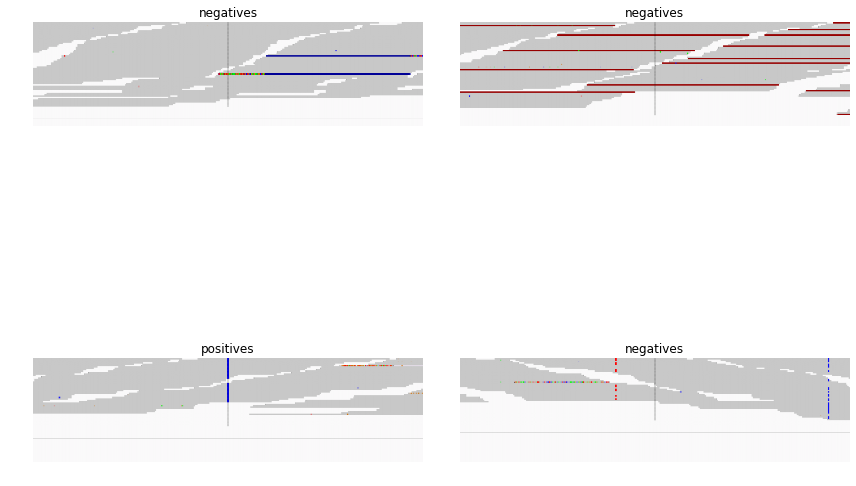

In [137]:
data.show_batch(rows=2, figsize=(12, 12))

In [138]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), #len(data.test_ds)

(['positives', 'negatives'], 2, 6648, 1661)

## Train model

In [139]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [140]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


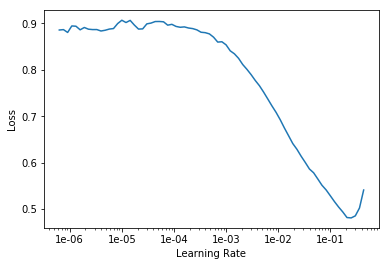

In [141]:
learn.recorder.plot()

In [142]:
learn.fit_one_cycle(2, max_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.107136,0.055317,0.987357,01:09
1,0.039615,0.019748,0.993980,01:08


In [143]:
learn.save('stage-1')

In [144]:
learn.unfreeze()

lr_find fail to run periodically, is this due to memery issue? no. it stops because the loss get much worse.

In [145]:
learn.lr_find(start_lr=1e-8, end_lr=1e-3, stop_div=False) # if stop_div=True it will stop when the loss get much worse

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [264]:
# learn.lr_find()

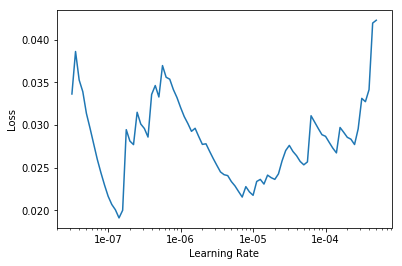

In [146]:
learn.recorder.plot()

In [266]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [147]:
learn.fit_one_cycle(2, max_lr=5e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.023217,0.018570,0.993980,01:32
1,0.017776,0.017070,0.994582,01:32


In [148]:
learn.save('stage-2')

## Interpretation

In [149]:
learn.load('stage-2');

In [150]:
interp = ClassificationInterpretation.from_learner(learn)

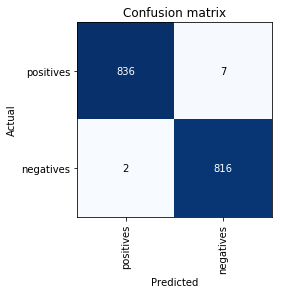

In [151]:
interp.plot_confusion_matrix()

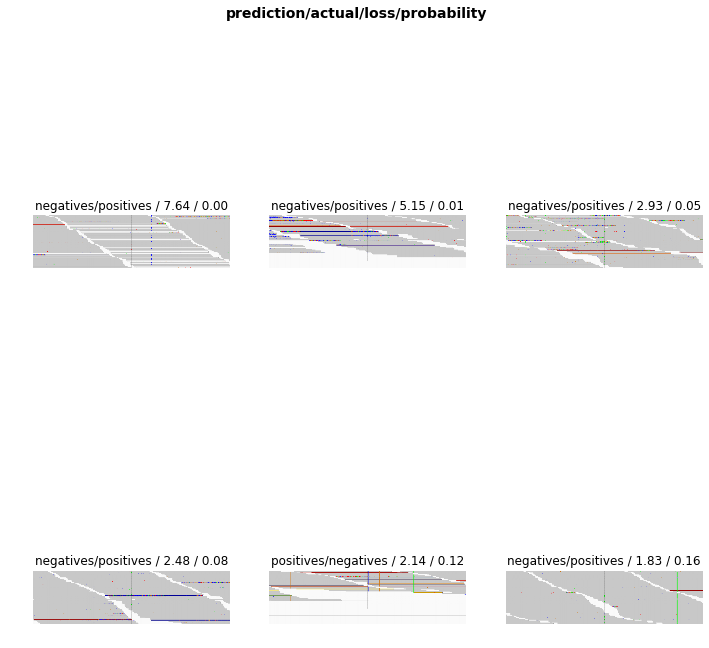

In [152]:
interp.plot_top_losses(6, heatmap=False)
# "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."

In [387]:
interp.ds

LabelList (1118 items)
x: ImageList
Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500)
y: CategoryList
ps,ps,ns,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images/train

# heatmap

Category negatives

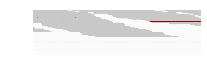

In [169]:
idx=805
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [170]:
x.shape

torch.Size([3, 200, 750])

In [171]:
m = learn.model.eval();

In [174]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

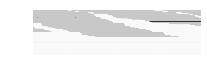

In [175]:
show_image(data.denorm(xb)[0])
# show_image(xb[0]) # normalized 

In [176]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

torch.Size([512, 7, 24])

torch.Size([7, 24])

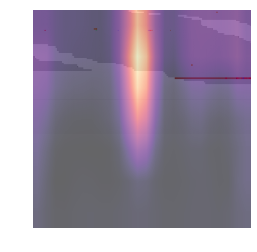

In [177]:
hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape
avg_acts = acts.mean(0)
avg_acts.shape
show_heatmap(avg_acts)

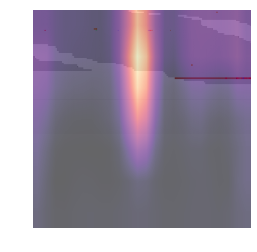

In [178]:
_,ax = plt.subplots()
xb_im.show(ax)
ax.imshow(avg_acts, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma')
of = '/projects/da_workspace/szspace/data/giab_imgs/hm.png'
plt.savefig(of, bbox_inches='tight')

In [29]:
show_heatmap??

# predict test set

by definition, test data set does not have labels, can I load the model and pretend the test set is validation set and get the test accuracy? yes. instead of specify val_pct, give a directory

In [392]:
ImageDataBunch.from_folder??

In [69]:
# path = '/projects/da_workspace/szspace/data/giab/images'
# there should not have other image folders in path
# test_path


In [179]:
path.ls()

[PosixPath('/projects/da_workspace/szspace/data/giab_imgs/models'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/hm.png'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/test.batch'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/my.ipynb'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/train'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/pog_imgs')]

In [180]:
classes

['positives', 'negatives']

In [181]:
np.random.seed(42)
data_test = ImageDataBunch.from_folder(path, 
                                  train="train",
                                  valid='pog_imgs',
#                                   valid_pct=0.2, 
                                  classes=classes,
                                  ds_tfms=tfms, 
                                  size=img_sz, bs=bs, 
                                  num_workers=4).normalize(imagenet_stats)

In [182]:
data_test

ImageDataBunch;

Train: LabelList (7997 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Valid: LabelList (312 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Test: None

In [183]:
# set the model data attribute
learn.data = data_test
learn

Learner(data=ImageDataBunch;

Train: LabelList (7997 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Valid: LabelList (312 items)
x: ImageList
Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750),Image (3, 200, 750)
y: CategoryList
positives,positives,positives,positives,positives
Path: /projects/da_workspace/szspace/data/giab_imgs;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

accuracy is 0.9230769276618958


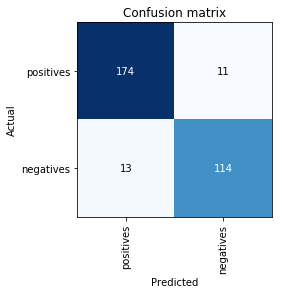

In [184]:
interp = ClassificationInterpretation.from_learner(learn)
acc = (interp.pred_class == interp.y_true).float().mean()
print(f'accuracy is {acc}')
interp.plot_confusion_matrix()

In [186]:
interp.plot_top_losses??

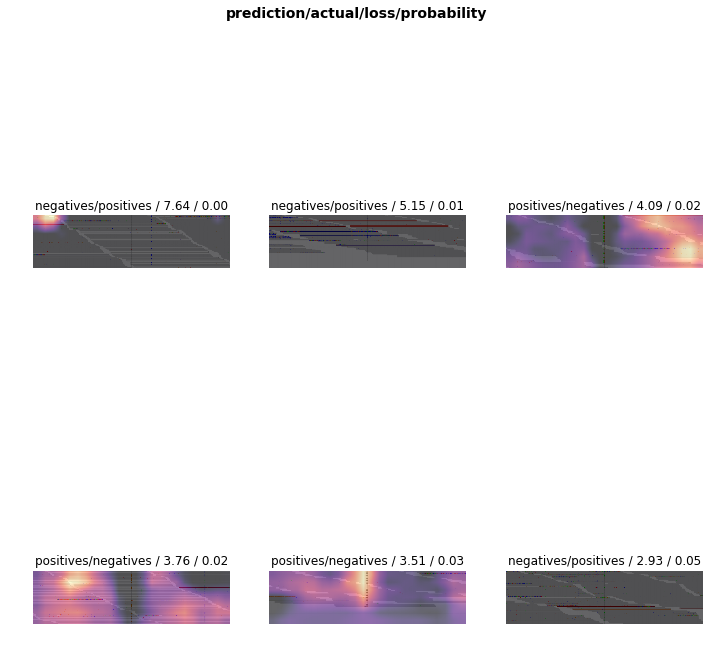

In [187]:
interp.plot_top_losses(6, heatmap=True)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [188]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [189]:
defaults.device = torch.device('cpu')

In [190]:
path.ls()

[PosixPath('/projects/da_workspace/szspace/data/giab_imgs/models'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/hm.png'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/test.batch'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/my.ipynb'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/train'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/pog_imgs'),
 PosixPath('/projects/da_workspace/szspace/data/giab_imgs/export.pkl')]

In [197]:
img = open_image('/projects/da_workspace/szspace/data/pog664_posorg/proc/chr7_100,676,184_100,676,484.png')
img = open_image('/projects/da_workspace/szspace/data/pog664_posorg/proc/chr11_47,609,711_47,610,011.png')
learn = load_learner(path)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category positives

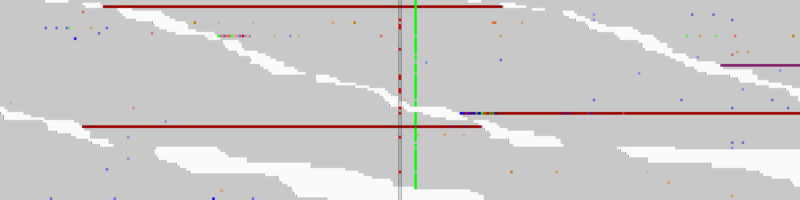

In [198]:
img